In [2]:
import stim
import pymatching


DISTANCE = 3
ROUNDS = 10
SHOTS = int(1e5)

after_clifford_depolarization = 0.8e-3
after_reset_flip_probability = 0.1e-2
before_measure_flip_probability = 0.5e-2 
before_round_data_depolarization = 0.8e-2

circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=after_clifford_depolarization, #two-qubit-fidelity,
                                after_reset_flip_probability=after_reset_flip_probability, #reset error,
                                before_measure_flip_probability=before_measure_flip_probability, #measurement error,
                                before_round_data_depolarization=before_round_data_depolarization) #idle error)
# print(circuit)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

# Meas Sampling

In [3]:
meas_outcomes = circuit.compile_sampler().sample(SHOTS)
print(meas_outcomes)
print()
print(meas_outcomes.shape)
print()
print(len(meas_outcomes[0]))
print(DISTANCE + ROUNDS*(DISTANCE-1))

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ...  True False False]
 [False False False ... False False  True]]

(100000, 23)

23
23


In [4]:
counts = {}
for row in meas_outcomes:
    count_str = ''
    for nb, bit in enumerate(row):
        count_str += '0' if bit == False else '1'
        if (nb+1) % (DISTANCE-1) == 0 and nb < ROUNDS*(DISTANCE-1):
            count_str += ' ' 
    
    count_str = count_str[::-1]
    if count_str in counts:
        counts[count_str] += 1
    else:
        counts[count_str] = 1
print(counts)

{'000 00 00 00 00 00 00 00 00 00 00': 72525, '000 00 00 00 00 00 00 00 10 00 00': 471, '010 11 11 11 11 11 11 11 00 00 00': 393, '001 01 01 00 00 00 00 00 00 00 00': 404, '100 10 10 00 00 00 00 00 00 00 00': 449, '001 01 01 01 01 01 01 01 01 01 00': 428, '001 01 01 01 01 01 01 01 01 00 00': 427, '100 10 10 10 10 10 00 00 00 00 00': 421, '010 11 11 11 01 00 00 00 00 00 00': 33, '000 00 01 00 00 00 00 00 00 00 00': 483, '000 01 00 00 00 00 00 00 00 00 00': 479, '001 00 00 00 00 00 00 00 00 00 00': 391, '010 11 11 11 11 11 11 11 11 11 00': 421, '010 11 11 11 11 11 00 00 00 00 00': 385, '010 11 11 11 11 11 11 11 11 00 00': 427, '000 00 00 00 00 01 00 00 00 00 00': 511, '000 00 00 00 10 00 00 00 00 00 00': 446, '100 10 00 00 00 00 00 00 00 01 00': 2, '000 00 00 00 00 00 01 00 00 00 00': 474, '001 01 01 01 01 01 01 01 00 00 00': 403, '001 01 00 01 01 01 01 01 00 00 00': 3, '100 10 10 10 10 00 00 00 00 00 00': 419, '000 10 00 00 00 00 00 00 00 00 00': 444, '010 11 11 11 00 00 00 00 00 00 00':

In [5]:
circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=after_clifford_depolarization, #two-qubit-fidelity,
                                after_reset_flip_probability=after_reset_flip_probability, #reset error,
                                before_measure_flip_probability=before_measure_flip_probability, #measurement error,
                                before_round_data_depolarization=before_round_data_depolarization) #idle error)


model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

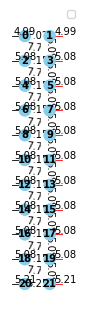

In [6]:
from soft_info import draw_matching_graph

draw_matching_graph(matching, DISTANCE, ROUNDS, scale_factor=0.6, figsize=(3,3))

In [26]:
# decode the meas outcomes
from cpp_soft_info import counts_to_det_syndr

num_err = 0
for count_key, val in counts.items():
    syndr = counts_to_det_syndr(count_key, _resets = True, verbose = False)
    predicted_flip = matching.decode(syndr)
    if int(predicted_flip[0]) != int(count_key[0]):
        num_err += val

print(f"Num errors: {num_err} out of {sum(counts.values())} shots")

Num errors: 359 out of 100000 shots


# Optimization

In [194]:
from scipy.optimize import minimize, differential_evolution

def f(parameters):
    after_clifford_depolarization, after_reset_flip_probability, before_measure_flip_probability, before_round_data_depolarization = parameters
    circuit = stim.Circuit.generated("repetition_code:memory",
                                     distance=DISTANCE,
                                     rounds=ROUNDS,
                                     after_clifford_depolarization=after_clifford_depolarization,
                                     after_reset_flip_probability=after_reset_flip_probability,
                                     before_measure_flip_probability=before_measure_flip_probability,
                                     before_round_data_depolarization=before_round_data_depolarization)

    model = circuit.detector_error_model(decompose_errors=True)
    matching = pymatching.Matching.from_detector_error_model(model)

    num_err = 0
    for count_key, val in counts.items():
        syndr = counts_to_det_syndr(count_key, _resets=True, verbose=False)
        predicted_flip = matching.decode(syndr)
        if int(predicted_flip[0]) != int(count_key[0]):
            num_err += val

    return num_err

# Initial guesses for the parameters
initial_guess = [after_clifford_depolarization, after_reset_flip_probability, before_measure_flip_probability, before_round_data_depolarization]  # example values
bounds = [(0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5)]
# bounds = [(0, 0.5), (0, 0.5), (0, 0.5)]

# Perform the minimization
# result = minimize(f, initial_guess, method='L-BFGS-B', bounds=bounds)
result = differential_evolution(f, bounds)
print("[after_clifford_depolarization, after_reset_flip_probability, before_measure_flip_probability, before_round_data_depolarization] = ")
print(result.x)
# print("probabs:", result.x * 0.8e-3)
print("\ninitial_guess =", initial_guess)
print("\nwith num_errors =", result.fun)
print("\n", result)

[after_clifford_depolarization, after_reset_flip_probability, before_measure_flip_probability, before_round_data_depolarization] = 
[0.0440642  0.07617156 0.0134095  0.02836362]

initial_guess = [0.0008, 0.001, 0.005, 0.008]

with num_errors = 354.0

  message: Optimization terminated successfully.
 success: True
     fun: 354.0
       x: [ 4.406e-02  7.617e-02  1.341e-02  2.836e-02]
     nit: 26
    nfev: 1625


# Ratios

In [205]:
ratios = result.x[1:] / result.x[0]
print(ratios)



[1.72864976 0.30431727 0.64368848]


In [206]:
circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=after_clifford_depolarization, #two-qubit-fidelity,
                                after_reset_flip_probability=after_clifford_depolarization * ratios[0], #reset error,
                                before_measure_flip_probability=after_clifford_depolarization * ratios[1], #measurement error,
                                before_round_data_depolarization=after_clifford_depolarization * ratios[2]) #idle error)


model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [207]:
# decode the meas outcomes
from cpp_soft_info import counts_to_det_syndr

num_err = 0
for count_key, val in counts.items():
    syndr = counts_to_det_syndr(count_key, _resets = True, verbose = False)
    predicted_flip = matching.decode(syndr)
    # print(count_key[0])
    # print(predicted_flip[0])
    if int(predicted_flip[0]) != int(count_key[0]):
        num_err += val

print(f"Num errors: {num_err} out of {sum(counts.values())} shots")

Num errors: 376 out of 100000 shots


# Detector sampling

In [96]:
syndromes = circuit.compile_detector_sampler().sample(SHOTS, append_observables=True)
print(syndromes.shape)
print(syndromes)



(100000, 9)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False  True]]


### Generate second stim for decoding

In [97]:
circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=after_clifford_depolarization, #two-qubit-fidelity,
                                after_reset_flip_probability=after_reset_flip_probability, #reset error,
                                before_measure_flip_probability=before_measure_flip_probability, #measurement error,
                                before_round_data_depolarization=before_round_data_depolarization) #idle error)


model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [98]:
num_err = 0

for i in range(len(syndromes))[:]:
    predicted_flip = matching.decode(syndromes[i][:-1])
    if bool(predicted_flip[0]) != (syndromes[i][-1]):
        num_err += 1

print("Error rate:", num_err, "out of:", len(syndromes), "total")  



Error rate: 824 out of: 100000 total
